*This file, part of the* [SdePy](https://github.com/sdepy/sdepy) *package*,
*was automatically generated from* `./doc/quickguide.rst`

-----------------------------------------------
Quick Guide
===========

*(this is a test file)*

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
import sdepy
from sdepy import *  # safe and handy for interactive sessions
import numpy as np
import scipy
import matplotlib.pyplot as plt  # optional, if plots are needed
plt.rcParams['figure.figsize'] = (11., 5.5)
plt.rcParams['lines.linewidth'] = 1.


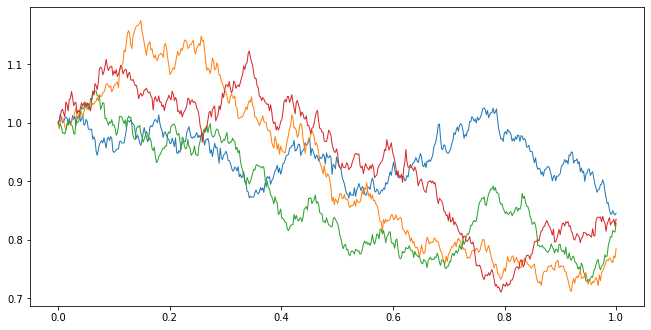

In [2]:
t = np.linspace(0, 1, 500)
x = sdepy.lognorm(t, sigma=0.2, paths=4)
gr = plt.plot(t, x)
